In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Loading train set from: ./jhu_crowd_v2.0/train
train batch shape: torch.Size([16, 1, 256, 256])
train crowd counts: tensor([ 35., 874.,  48.,  15.,  99., 671., 128.,   7., 362.,  12.,   4., 124.,
        164., 893., 107.,  19.])

Loading val set from: ./jhu_crowd_v2.0/val
val batch shape: torch.Size([16, 1, 256, 256])
val crowd counts: tensor([804.,  41.,  26.,  31.,  40.,  35.,  96.,  32., 140., 210.,  90., 133.,
        144., 408.,  60.,  20.])

Loading test set from: ./jhu_crowd_v2.0/test
test batch shape: torch.Size([16, 1, 256, 256])
test crowd counts: tensor([ 43.,  59., 463., 299., 140.,  28.,  45.,  33.,  50.,  55., 284., 275.,
         52., 212., 134., 270.])


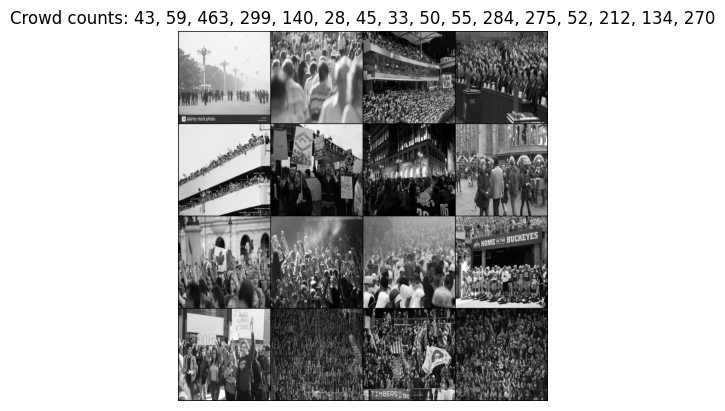

In [15]:
# Pre Processing

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images_dir = os.path.join(data_dir, 'images')
        self.label_path = os.path.join(data_dir, 'image_labels.txt')
        self.transform = transform

        self.samples = []
        with open(self.label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 2:
                    image_id = parts[0]
                    count = float(parts[1])
                    if count > 1000:
                        continue  # skip this image
                    filename = image_id + '.jpg'
                    self.samples.append((filename, count))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, count = self.samples[idx]
        image_path = os.path.join(self.images_dir, filename)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        count = torch.tensor(count, dtype=torch.float32)

        return image, count

# Shared preprocessing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define paths to each data split
base_dir = './jhu_crowd_v2.0'
splits = {
    'train': os.path.join(base_dir, 'train'),
    'val': os.path.join(base_dir, 'val'),
    'test': os.path.join(base_dir, 'test')
}

# Load and preview each split
if __name__ == '__main__':
    for split_name, path in splits.items():
        print(f"\nLoading {split_name} set from: {path}")
        dataset = CrowdDataset(data_dir=path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=(split_name == 'train'))

        for images, counts in dataloader:
            print(f"{split_name} batch shape:", images.shape)
            print(f"{split_name} crowd counts:", counts)
            break


# JUST TO VISUALIZE THAT ITS WORKING:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# Show first N samples in a grid
N = 16
images = []
labels = []

for i in range(N):
    img, count = dataset[i]
    img = img * 0.5 + 0.5  # unnormalize
    images.append(img)
    labels.append(f"{int(count.item())}")

# Combine into a single grid
grid = make_grid(torch.stack(images), nrow=4, padding=2)
np_grid = TF.to_pil_image(grid)

plt.imshow(np_grid, cmap='gray')
plt.axis('off')
plt.title("Crowd counts: " + ", ".join(labels))
plt.show()


def export_tensor_dataset(dataset, output_path='tensor_dataset.pt'):
    data = []
    for img, count in dataset:
        data.append((img, torch.tensor(count)))  # convert count to tensor for consistency

    torch.save(data, output_path)

In [16]:
#Model Definition

import torchvision.models as models
import torch.nn as nn

class ResNetCrowdRegressor(nn.Module):
    def __init__(self):
        super(ResNetCrowdRegressor, self).__init__()
        resnet = models.resnet18(pretrained=True)

        # If using grayscale images, change first conv layer
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # remove avgpool + FC
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x.squeeze(1)



In [17]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())

    return running_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    loop = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

    return total_loss / len(dataloader.dataset)


In [19]:
# Training loop

# Load datasets
train_dataset = CrowdDataset(splits['train'], transform=transform)
val_dataset = CrowdDataset(splits['val'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize model, loss, optimizer
model = ResNetCrowdRegressor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_model(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



Epoch 1/4


Train Loss: 54276.2008 | Val Loss: 40276.6959

Epoch 2/4


Train Loss: 32556.5970 | Val Loss: 26948.7909

Epoch 3/4


Train Loss: 18232.7715 | Val Loss: 19105.8793

Epoch 4/4


Train Loss: 11177.6416 | Val Loss: 19112.1806


In [ ]:
test_dataset = CrowdDataset(splits['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16)

test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Test MSE: {test_loss:.4f}")

Test MSE: 29382.6445


In [20]:
from PIL import Image
import torch

def predict_count_from_image(model, image_path, transform, device='cpu'):
    """
    Predict the crowd count for a single image.
    
    Args:
        model: Trained CNN model.
        image_path (str): Path to the image file.
        transform: The preprocessing transform used during training.
        device: 'cuda' or 'cpu'.
    
    Returns:
        float: Predicted crowd count.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        prediction = model(image)
        predicted_count = prediction.item()

    return predicted_count

In [24]:
test_image_path = "./jhu_crowd_v2.0/test2.jpeg"  # or any path
predicted = predict_count_from_image(model, test_image_path, transform, device)
print(f"Predicted Crowd Count: {predicted:.2f}")

Predicted Crowd Count: 21.49
